In [3]:
import pandas as pd
pd.set_option('display.max_rows', 10000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as torch_utils
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt


In [4]:
#%%
# %%
# INDOORS 1 SUN
file = pd.ExcelFile('Indoor MPP_ICN2_Nov. 2022_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')# the whole excel file 
sn = file.sheet_names # sheets that are the excel file 
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl') # read the data from the first sheet 

temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy() #take the temperature from the row Annealing temperature of column Parameters and convert it to numpy
temperature = temperature[2,2:] # take everything from temperature starting from the third row and the third column
 
devices = data_frame.columns.to_numpy() # take the devices from the data and convert them to numpy
 
devices = np.reshape(devices, (devices.shape[0],1)) 
devices = devices[2:] #excluding the first two elements

time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl') # read the data from the last sheet

time_series_df = time_series_df.drop(index =[0]) # drop the first row (einheiten)
time = time_series_df.iloc[:,0] # take the time from the first column



# print(time)
time_series_1_sun = []
for i in range (temperature.shape[0]):
    time_series_1_sun.append(time_series_df.iloc[:,2+i*3]) ### for every device take the impp (optimal current output that the solar panel can generate when it is operating at its maximum power point)

time_series_1_sun = np.array(time_series_1_sun) # convert it to array [shape(24, 4001)]


# %% 
# 1.4 SUN

file = pd.ExcelFile('Indoor MPP_1.4 sun_ICN2_Feb. 2023_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')
sn = file.sheet_names
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')

# temperature
devices = data_frame.columns.to_numpy()
devices = np.reshape(devices, (devices.shape[0],1))
devices = devices[2:]
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')
time_series_df = time_series_df.drop(index =[0])
time = time_series_df.iloc[:,0]

# print(time)
time_series_1_4_sun = []
for i in range (temperature.shape[0]):
    time_series_1_4_sun.append(time_series_df.iloc[:,2+i*3])
time_series_1_4_sun = np.array(time_series_1_4_sun)#[shape(24, 1313)]



# %%
# %%
# OUTDOOR CONDITIONS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_conditions = pd.read_csv('outdoor_conditions_unnormalized.txt', sep='\t')

irradiance = outdoor_conditions['irradiance'] #[shape(4794,)]
rh = outdoor_conditions['rh'] #[shape(4794,)]
 
outdoor_temperature = outdoor_conditions['outdoor_temperature'] #[shape(4794,)]

outdoor_condition_time = outdoor_conditions['time'] #[shape(4794,)] 
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
outdoor_temperature = outdoor_temperature.fillna(outdoor_temperature.mean())
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
scaler = MinMaxScaler()
 
# Normalize irradiance column
irradiance_normalized = scaler.fit_transform(outdoor_conditions['irradiance'].values.reshape(-1, 1))

# Normalize rh column
rh_normalized = scaler.fit_transform(outdoor_conditions['rh'].values.reshape(-1, 1))

# Normalize outdoor_temperature column
outdoor_temperature_normalized = scaler.fit_transform(outdoor_conditions['outdoor_temperature'].values.reshape(-1, 1))

# Create a new DataFrame with normalized columns
outdoor_conditions_normalized = pd.DataFrame({
    'irradiance_normalized': irradiance_normalized.flatten(),
    'rh_normalized': rh_normalized.flatten(),
    'outdoor_temperature_normalized': outdoor_temperature_normalized.flatten(),
    'time': outdoor_conditions['time']
})

# Save the normalized DataFrame to a new file
outdoor_conditions_normalized.to_csv('outdoor_conditions_normalized.txt', sep='\t')
outdoor_conditions_normalized=pd.read_csv('outdoor_conditions_normalized.txt', sep='\t')
# %%
# OUTDOOR PANELS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_panels = pd.read_csv('outdoor_data_imputed.txt', sep ='\t')
# outdoor_panels.head()
outdoor_panels_power = [] 
for i in range(temperature.shape[0]):
    outdoor_panels_power.append(outdoor_panels[str(i)])
outdoor_panels_power = np.array(outdoor_panels_power) #[shape(24, 4794)]

#%%
# Padding


time_series_1_sun_shape = time_series_1_sun.shape
time_series_1_4_sun_shape = time_series_1_4_sun.shape
time_series_1_sun = np.pad(time_series_1_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_sun.shape[1])),mode='edge')    
time_series_1_4_sun = np.pad(time_series_1_4_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_4_sun.shape[1])),mode='edge' )    
time_series_1_sun = np.reshape(time_series_1_sun, ((time_series_1_sun.shape[0],time_series_1_sun.shape[1],1)))
time_series_1_4_sun = np.reshape(time_series_1_4_sun, ((time_series_1_4_sun.shape[0],time_series_1_4_sun.shape[1],1)))
outdoor_panels_power = np.reshape(outdoor_panels_power, ((outdoor_panels_power.shape[0],outdoor_panels_power.shape[1],1)))
 
#shape[(24, 4794, 1) (24, 4794, 1) (4794, 5) (24, 4794, 1)]

In [5]:
# Calculate average values for time_series_1_sun
time_series_1_sun_average = np.zeros((12, 4794, 1))
j = 0
for i in range(time_series_1_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_sun_average[j] = np.mean(time_series_1_sun[i-1:i+1], axis=0)
        j += 1
 
     

# Calculate average values for time_series_1_4_sun
time_series_1_4_sun_average = np.zeros((12, 4794, 1))
k = 0
for i in range(time_series_1_4_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_4_sun_average[k] = np.mean(time_series_1_4_sun[i-1:i+1], axis=0)
        k += 1

# Calculate average values for outdoor_panels_power
outdoor_panels_power_average = np.zeros((12, 4794, 1))
b = 0
for i in range(outdoor_panels_power.shape[0]):
    if (i+1) % 2 == 0:
        outdoor_panels_power_average[b] = np.mean(outdoor_panels_power[i-1:i+1], axis=0)
        outdoor_panels_power_average[b][outdoor_panels_power_average[b] < 0] = 0 # Set negative values to 0
        b += 1

# Stack the outdoor conditions
outdoor_conditions_stacked = np.stack([outdoor_conditions ] * 12, axis=0)
outdoor_conditions_stacked_2= np.stack([outdoor_conditions] * 20, axis=0)

In [6]:
# Define a function to smooth and replace negative values in an array using Savitzky-Golay filter
def smooth_and_replace(array, window_length, polyorder):
    smoothed_array = np.zeros_like(array)
    t = 0
    for i in range(array.shape[0]):
        # Get the time series from the array
        time_series = array[i, :, 0]
        
        # Apply Savitzky-Golay filter to smooth the time series
        smoothed_series = savgol_filter(time_series, window_length + t, polyorder)
        
        # Set negative values to 0
        smoothed_series[smoothed_series < 0] = 0
        
        # Update the smoothed_array with the smoothed time series
        smoothed_array[i, :, 0] = smoothed_series
        
        # Increment window_length for the next iteration (if needed)
        t = t + 1
    
    return smoothed_array

# Function to add noise to the array
def add_noise(array, noise_std):
    # Generate random noise with the specified standard deviation
    noise = np.random.normal(loc=0, scale=noise_std, size=array.shape)
    
    # Add the noise to the array
    noisy_array = array + noise
    
    # Set negative values to 0 after adding noise
    noisy_array[noisy_array < 0] = 0
    
    return noisy_array

# Apply the smooth_and_replace function to outdoor_panels_power_average array
outdoor_panels_power_average = smooth_and_replace(outdoor_panels_power_average, window_length=40, polyorder=3)

# Apply the smooth_and_replace function to time_series_1_sun_average array
time_series_1_sun_average = smooth_and_replace(time_series_1_sun_average, window_length=40, polyorder=3)

# Set noise standard deviations for outdoor panels power and time series
noise_std_outdoor = 0.1
noise_std_time_series = 0.1

k = 0
c = 0
for i in range(outdoor_panels_power_average.shape[0]):
    # Add noise to outdoor panels power array with increasing noise_std
    outdoor_panels_power_average[i, :, :] = add_noise(outdoor_panels_power_average[i, :, :], noise_std_outdoor + k)
    
    # Add noise to time_series_1_sun_average array with increasing noise_std
    time_series_1_sun_average[i, :, :] = add_noise(time_series_1_sun_average[i, :, :], noise_std_time_series + c)
    
    # Increment noise_std for the next iteration
    k = k + 0.005
    c = c + 0.005




In [7]:
# Concatenate the arrays time_series_1_sun_average and outdoor_conditions_stacked along the third dimension (axis=2)
all_new_features = np.concatenate((time_series_1_sun_average, outdoor_conditions_stacked), axis=2)

# Print the shape of the array outdoor_panels_power_average
print(outdoor_panels_power_average.shape)


(12, 4794, 1)


In [8]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available. Using GPU for computations.')
else:
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU for computations.')

CUDA is not available. Using CPU for computations.


In [9]:
# Extract the first 10 samples of all_new_features as the training data and convert it to float32 type
all_new_features_train = all_new_features[0:10, :, :].astype(np.float32)

# Convert the training data to a PyTorch tensor and move it to the device (e.g., GPU) if available
all_new_features_train = torch.from_numpy(all_new_features_train).float().to(device)

# Extract the first 10 samples of outdoor_panels_power_average as the target data and convert it to float type
target = torch.from_numpy(outdoor_panels_power_average[0:10, :, :]).float().to(device)



In [10]:

import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers

        # Define LSTM layers
        self.lstm_layers = nn.ModuleList()
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True))
        for _ in range(num_layers - 1):
            self.lstm_layers.append(nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True))

        # Define fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, 64)  # Fully connected layer 1
        self.fc2 = nn.Linear(64, 32)  # Fully connected layer 2
        self.fc3 = nn.Linear(32, output_dim)  # Fully connected layer 3
        self.leaky_relu = nn.LeakyReLU(0.001)
        self.prelu = nn.PReLU()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout layer for regularization

        for m in self.modules():
          if isinstance(m, nn.Linear):
            init.kaiming_normal_(m.weight)
            if m.bias is not None:
                # Initialize the bias with a random number between 0 and 1
                init.constant_(m.bias, 0)
          elif isinstance(m, nn.LSTM):
              for name, param in m.named_parameters():
                 if 'weight' in name:
                   init.kaiming_normal_(param)
                 elif 'bias' in name:
                    # Initialize the bias with a random number between 0 and 1
                    init.constant_(param, 0)
    def silu(self, x):
        return x * torch.sigmoid(x)
    def forward(self, x):
        # Iterate through LSTM layers
        for i in range(self.num_layers):
            if i == 0:
                lstm_output, _ = self.lstm_layers[i](x)  # Apply the first LSTM layer
            else:
                lstm_output, _ = self.lstm_layers[i](lstm_output)  # Apply subsequent LSTM layers
        
        # Apply fully connected layers
        output = self.fc1(lstm_output)  # Apply fully connected layer 1
        output = self.relu(output)  # Apply ReLU activation
        output = self.dropout(output)  # Apply dropout for regularization
        output = self.fc2(output)  # Apply fully connected layer 2
        output = self.relu(output)  # Apply ReLU activation
        output = self.dropout(output)  # Apply dropout for regularization
        output = self.fc3(output)  # Apply fully connected layer 3
        
        return output




 







Mean Squared Error (MSE): 1.3969625234603882


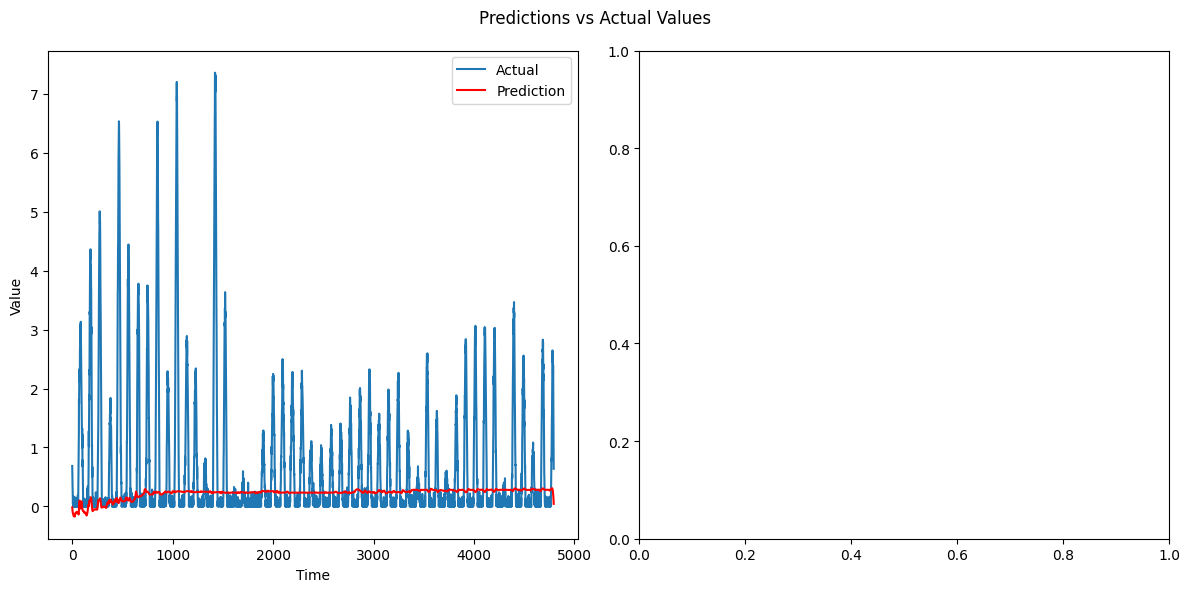

Mean Squared Error (MSE): 1.080554723739624


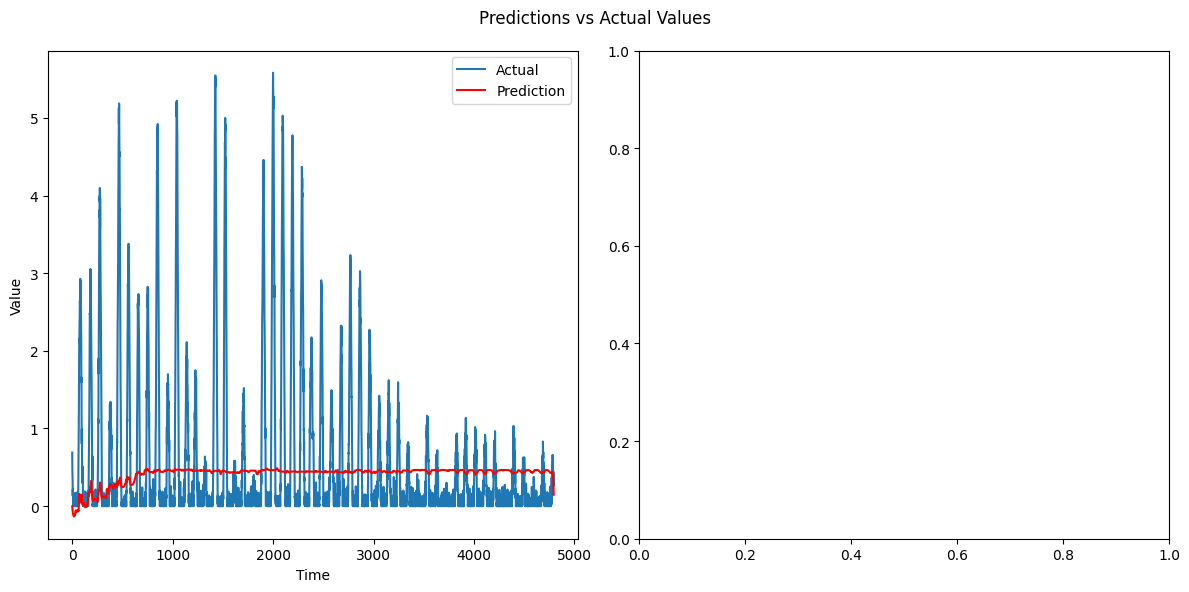

In [11]:
# Define the hyperparameters for the LSTM model
input_dim = 6  # Number of features in the outdoor conditions and the indoor measurements
hidden_dim = 128
output_dim = 1  # Number of features in the output
num_epochs = 1
num_layers = 4
num_mixtures = 5
learning_rate = 0.001
weight_decay = 0.1
Fold = 0

# Initialize arrays to store predictions and test targets
Predictions = np.zeros((6, 4794, 1))
Test = np.zeros((6, 4794, 1))

# Create a KFold cross-validator with 10 folds
kf = KFold(n_splits=10)

# Initialize the LSTM model, loss function, and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(all_new_features_train):
    # Split the data into training and test sets for the current fold
    train_input = all_new_features_train[train_index]
    train_target = target[train_index]
    test_input = all_new_features_train[test_index]
    test_target = target[test_index]

    # Training loop for the current fold
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        outputs = model(train_input)  # Forward pass
        outputs = outputs.view(train_input.shape[0], 4794, 1)  # Reshape the outputs
        loss = criterion(outputs, train_target)  # Calculate the loss
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backward pass to calculate gradients
        torch_utils.clip_grad_norm_(model.parameters(), 5)  # Clip gradients to avoid exploding gradients
        optimizer.step()  # Update model parameters using the optimizer

    model.eval()  # Set the model to evaluation mode for testing
    with torch.no_grad():
        sample_input = test_input
        predictions = model(sample_input)  # Make predictions on the test set
        Predictions[Fold] = predictions.numpy()  # Store the predictions
        Test[Fold] = test_target.numpy()  # Store the test targets
        mse = F.mse_loss(predictions, test_target)  # Calculate the Mean Squared Error (MSE)
        print("Mean Squared Error (MSE):", mse.item())

        # Plotting the predictions against the actual values for the current fold
        x = range(test_target.shape[1])
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        for i, axs in enumerate(axs.flat):
            axs.plot(x, test_target[i].flatten(), label='Actual')  # Plot the actual values
            axs.plot(x, predictions[i].flatten(), label='Prediction', color='red')  # Plot the predictions
            axs.set_xlabel('Time')
            axs.set_ylabel('Value')
            axs.legend()
            break
        fig.suptitle('Predictions vs Actual Values')  # Add a title to the figure
        plt.tight_layout()
        plt.show()

    Fold += 1  # Increment the fold counter

    # Break the loop after the second fold (remove this condition to perform all 10 folds)
    if Fold == 2:
        break

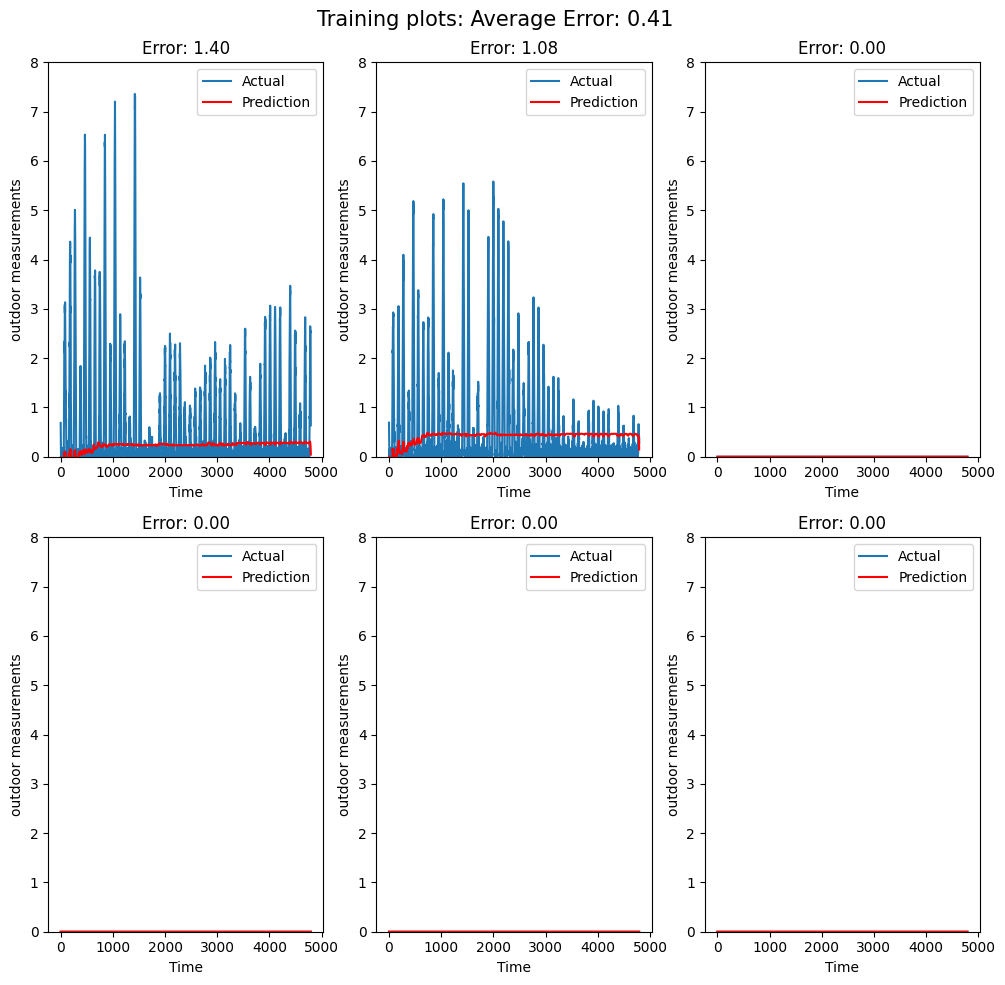

In [12]:
# Plot the predictions from the training set
x = range(Predictions.shape[1])
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
mse_scores = []

# Iterate over each panel's predictions
for i, axs in enumerate(axs.flat):
    # Plot the actual values and predictions for the current panel
    axs.plot(x, Test[i], label='Actual')
    axs.plot(x, Predictions[i], label='Prediction', color='red')
    axs.set_xlabel('Time')
    axs.set_ylabel('outdoor measurements')
    axs.legend()
    axs.set_ylim(0, 8)
    
    # Calculate the Mean Squared Error (MSE) for the current panel's predictions
    mse = F.mse_loss(torch.tensor(Predictions[i]), torch.tensor(Test[i]))
    mse_scores.append(mse.item())
    
    # Set the title for the current panel's plot with the calculated MSE
    axs.set_title(f'Error: {mse.item():.2f}')

# Calculate the average MSE error for all panels
average_error = np.mean(mse_scores)

# Set the figure title with the average MSE error
fig.suptitle(f'Training plots: Average Error: {average_error:.2f}', fontsize=15)

# Save the plot as "training.pdf" in the current working directory
plt.savefig('training.pdf')

# Ensure the plots are displayed neatly without overlapping
plt.tight_layout()

# Show the plot
plt.show()

Average MSE Error: 2.8989


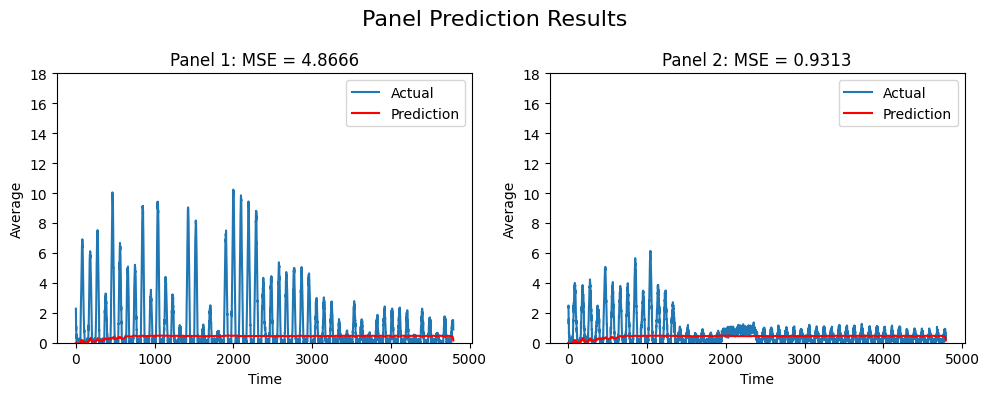

In [13]:
# Evaluate the model and plot the predictions from the test set
all_new_features_test = all_new_features[10:12, :, :].astype(np.float32)
outdoor_panels_power_0 = outdoor_panels_power_average[10:12].astype(float)
model.eval()
loss = []
outdoor_panels_power_t0 = torch.from_numpy(outdoor_panels_power_0).to(device)
all_new_features_test_0 = torch.from_numpy(all_new_features_test).float().to(device)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Add a title to the entire figure
fig.suptitle("Panel Prediction Results", fontsize=16)

# Iterate over the two panels for predictions
for i, ax in enumerate(axs.flat):
    with torch.no_grad():
        # Get the input and target sequences for the current panel
        train_in = all_new_features_test_0[i:i + 1, :, :]
        target_test = outdoor_panels_power_t0[i:i + 1, :, :]
        
        # Make predictions for the current panel
        pred = model(train_in)
        
        # Calculate the Mean Squared Error (MSE) for the current panel's predictions
        mse = F.mse_loss(pred[0], outdoor_panels_power_t0[i])
        loss.append(mse.item())
        
        # Set the x-axis values
        x = range(target_test.shape[1])
        
        # Plot the actual values and predictions for the current panel
        ax.plot(x, target_test[0], label='Actual')
        ax.plot(x, pred[0], label='Prediction', color='red')
        
        # Set the title for the current subplot with the calculated MSE
        ax.set_title("Panel {}: MSE = {:.4f}".format(i + 1, mse.item()))
        ax.set_xlabel('Time')
        ax.set_ylabel('Average')
        ax.legend()
        ax.set_ylim([0, 18])

# Ensure the plots are displayed neatly without overlapping
plt.tight_layout()

# Calculate the average of the MSE errors
mean_mse = np.mean(loss)
print("Average MSE Error: {:.4f}".format(mean_mse))

# Show the plot
plt.show()
